# 1. Data Loading and Cleaning



In [ ]:


import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import classification_report


#df = pd.read_csv('data.csv')
df = pd.read_csv('/content/labeled_data.csv')


# Keeping only necessary columns
df = df[['tweet', 'class']]





# 2. Basic Preprocessing



In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.2 MB/s eta 0:00:00


In [ ]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure you’ve run these once:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = emoji.demojize(text)
    text = re.sub(r':\w+?:', '', text)
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'#([A-Za-z0-9_]+)', r'\1', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    tokens = text.split()
    cleaned_tokens = []
    for tok in tokens:
        if tok not in stop_words:
            lemma = lemmatizer.lemmatize(tok)
            cleaned_tokens.append(lemma)

    # 10. Rejoin
    return ' '.join(cleaned_tokens)

# Apply
df['tweet'] = df['tweet'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 3. Dataset Preparation


In [ ]:
# Label Mapping
label_map = {
    0: "Hate Speech",
    1: "Offensive Language",
    2: "Neither"
}

In [ ]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

dataset = HateSpeechDataset(df['tweet'].tolist(), df['class'].tolist(), tokenizer)

# Split into train and validation
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# 4. Model Implementation



In [ ]:
class DistilBERTClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3, num_classes=3):
        super(DistilBERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]        # Take the first [CLS] token
        dropped_out = self.dropout(pooled_output)
        logits = self.fc(dropped_out)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBERTClassifier().to(device)

####################################################################################################

from tqdm import tqdm
import numpy as np

# Switch model to eval mode to extract embeddings
model.eval()
sentence_embeddings = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(DataLoader(dataset, batch_size=32)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']

        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        sentence_embeddings.append(cls_embeddings)
        all_labels.extend(labels.numpy())

X = np.vstack(sentence_embeddings)
y = np.array(all_labels)

!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Original class distribution:", np.bincount(y))
print("After SMOTE:", np.bincount(y_resampled))



####################################################################################################
# Optimizer and Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 775/775 [00:52<00:00, 14.62it/s]


Original class distribution: [ 1430 19190  4163]
After SMOTE: [19190 19190 19190]


# 5. Training and Evaluation


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train a simple classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=list(label_map.values())))

print("Lengths match:", len(y_val), len(y_pred))




                    precision    recall  f1-score   support

       Hate Speech       0.79      0.80      0.80      5742
Offensive Language       0.81      0.77      0.79      5733
           Neither       0.87      0.90      0.89      5796

          accuracy                           0.83     17271
         macro avg       0.82      0.83      0.83     17271
      weighted avg       0.83      0.83      0.83     17271

Lengths match: 17271 17271


# Confusion Matrix

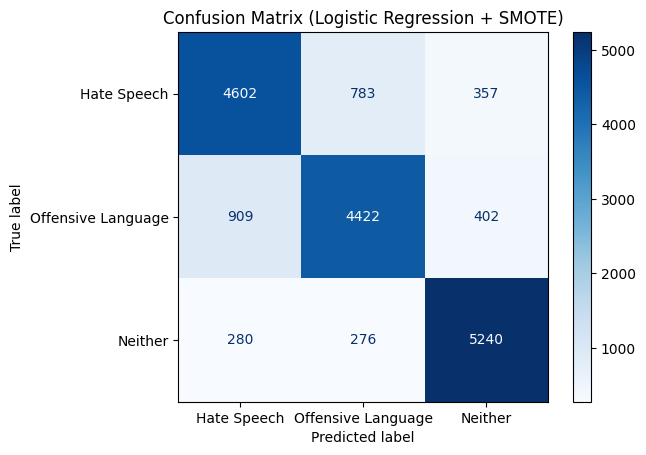

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Correct: Use predictions from Logistic Regression
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Logistic Regression + SMOTE)")
plt.show()

# Bar Chart for Class-wise Metrics

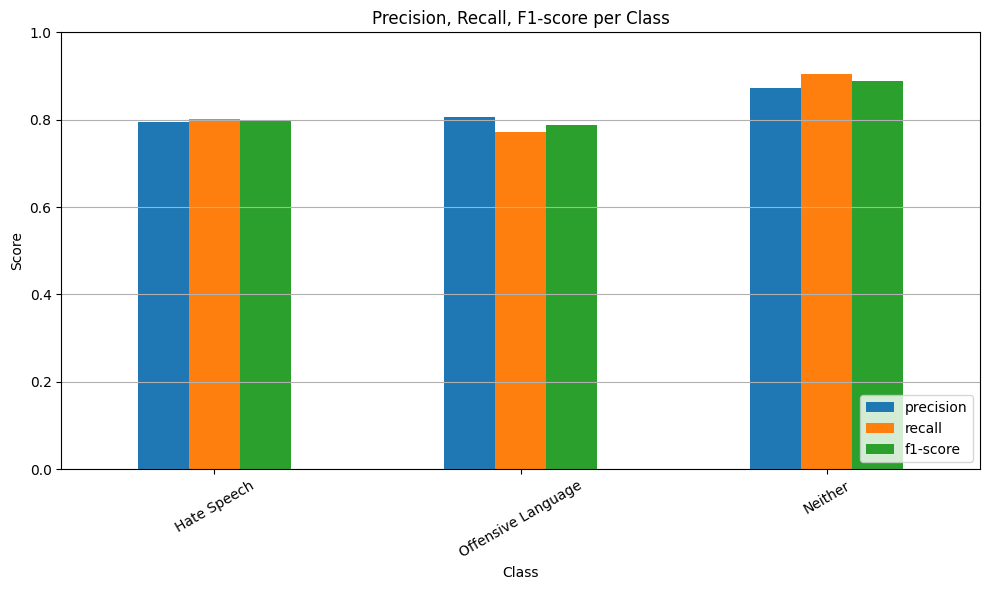

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Get report as dict
report_dict = classification_report(y_val, y_pred, target_names=list(label_map.values()), output_dict=True)

# Convert to DataFrame and remove accuracy/global rows
df_metrics = pd.DataFrame(report_dict).T
df_metrics = df_metrics.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plot
df_metrics[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, F1-score per Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Display table version
from IPython.display import display
display(df_metrics[['precision', 'recall', 'f1-score', 'support']].round(3))

,precision,recall,f1-score,support
Hate Speech,0.795,0.801,0.798,5742.0
Offensive Language,0.807,0.771,0.789,5733.0
Neither,0.873,0.904,0.889,5796.0


# Class Distribution: Before vs. After SMOTE

<ipython-input-12-aced76eeaf7e>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(label_map.values(), rotation=20)
<ipython-input-12-aced76eeaf7e>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(label_map.values(), rotation=20)


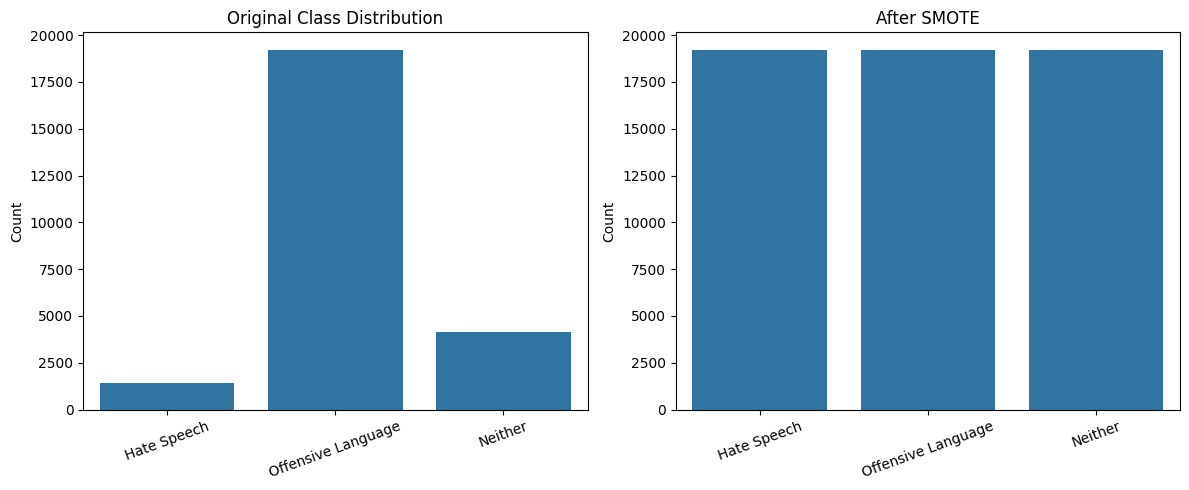

In [ ]:
import seaborn as sns
import pandas as pd

# Original
orig_counts = pd.Series(y).value_counts().sort_index()
smote_counts = pd.Series(y_resampled).value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=[label_map[i] for i in orig_counts.index], y=orig_counts.values, ax=axes[0])
axes[0].set_title('Original Class Distribution')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(label_map.values(), rotation=20)

sns.barplot(x=[label_map[i] for i in smote_counts.index], y=smote_counts.values, ax=axes[1])
axes[1].set_title('After SMOTE')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(label_map.values(), rotation=20)

plt.tight_layout()
plt.show()


# Learning Curve (Logistic Regression)

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    clf, X_resampled, y_resampled, cv=5, scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training F1", marker='o')
plt.plot(train_sizes, val_mean, label="Validation F1", marker='o')
plt.title("Learning Curve (F1 Macro)")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# 1) Use *imbalanced* labels here ‑‑ NO SMOTE
y = np.array(all_labels)          # labels gathered while embedding
X = np.vstack(sentence_embeddings)

# 2) class weights (balanced = inverse‑frequency)
weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = {cls: w for cls, w in zip(np.unique(y), weights)}
print("Weights:", weight_dict)

# 3) split & train
X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(
        max_iter=1000,
        class_weight=weight_dict,
        solver='lbfgs',           # or 'saga' if you use L1 penalty
        n_jobs=-1
)
clf.fit(X_train, y_train)

# 4) evaluate
print(classification_report(y_val, clf.predict(X_val),
                            target_names=list(label_map.values())))


Weights: {np.int64(0): np.float64(5.776923076923077), np.int64(1): np.float64(0.43048462741010945), np.int64(2): np.float64(1.9843862599087196)}
                    precision    recall  f1-score   support

       Hate Speech       0.20      0.57      0.29       429
Offensive Language       0.96      0.77      0.85      5757
           Neither       0.66      0.84      0.74      1249

          accuracy                           0.77      7435
         macro avg       0.61      0.72      0.63      7435
      weighted avg       0.87      0.77      0.80      7435



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC              # or LinearSVC for huge datasets
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# balanced class weights  (0 = non‑hate, 1 = hate, 2 = offensive, etc.)
classes   = np.unique(y)
cw        = compute_class_weight('balanced', classes=classes, y=y)
cw_dict   = {c:w for c, w in zip(classes, cw)}

# train/val split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)

# RBF‑kernel SVC with scaling + class weights
svm_clf = make_pipeline(
            StandardScaler(with_mean=False),      # sparse‑safe
            SVC(kernel='rbf',
                class_weight=cw_dict,
                C=5.0, gamma='scale', probability=False)
)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=list(label_map.values())))


                    precision    recall  f1-score   support

       Hate Speech       0.23      0.54      0.32       429
Offensive Language       0.96      0.80      0.87      5757
           Neither       0.67      0.87      0.76      1249

          accuracy                           0.80      7435
         macro avg       0.62      0.74      0.65      7435
      weighted avg       0.87      0.80      0.82      7435



In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------
# 1.  Torch tensors
# ------------------------------------------------------------------
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# split indices
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(
        np.arange(len(y)), test_size=0.3,
        stratify=y, random_state=42)

train_ds = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
val_ds   = TensorDataset(X_tensor[val_idx],   y_tensor[val_idx])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128)

# ------------------------------------------------------------------
# 2.  MLP definition
# ------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=768, hidden=256, n_classes=3, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_dim=X.shape[1],
            n_classes=len(np.unique(y))).to(device)

# ------------------------------------------------------------------
# 3.  Weighted Cross‑Entropy
# ------------------------------------------------------------------
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y),
                                     y=y)
class_weights = torch.tensor(class_weights,
                             dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
epochs    = 20

# ------------------------------------------------------------------
# 4.  Training loop
# ------------------------------------------------------------------
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    # ---- validation ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = torch.argmax(model(xb), dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    acc = correct / total
    print(f"Epoch {epoch:02d} | loss {running_loss/len(train_ds):.4f} | val‑acc {acc:.3f}")

# detailed report
from sklearn.metrics import classification_report
model.eval()
with torch.no_grad():
    y_pred = torch.argmax(model(X_tensor.to(device)), dim=1).cpu().numpy()
print(classification_report(y, y_pred, target_names=list(label_map.values())))


Epoch 01 | loss 0.8322 | val‑acc 0.790
Epoch 02 | loss 0.7249 | val‑acc 0.631
Epoch 03 | loss 0.6890 | val‑acc 0.788
Epoch 04 | loss 0.6633 | val‑acc 0.767
Epoch 05 | loss 0.6520 | val‑acc 0.782
Epoch 06 | loss 0.6461 | val‑acc 0.808
Epoch 07 | loss 0.6199 | val‑acc 0.725
Epoch 08 | loss 0.6124 | val‑acc 0.802
Epoch 09 | loss 0.5977 | val‑acc 0.825
Epoch 10 | loss 0.5974 | val‑acc 0.784
Epoch 11 | loss 0.5828 | val‑acc 0.794
Epoch 12 | loss 0.5731 | val‑acc 0.762
Epoch 13 | loss 0.5677 | val‑acc 0.751
Epoch 14 | loss 0.5612 | val‑acc 0.742
Epoch 15 | loss 0.5510 | val‑acc 0.712
Epoch 16 | loss 0.5451 | val‑acc 0.623
Epoch 17 | loss 0.5469 | val‑acc 0.712
Epoch 18 | loss 0.5343 | val‑acc 0.815
Epoch 19 | loss 0.5353 | val‑acc 0.770
Epoch 20 | loss 0.5202 | val‑acc 0.810
                    precision    recall  f1-score   support

       Hate Speech       0.32      0.60      0.42      1430
Offensive Language       0.96      0.83      0.89     19190
           Neither       0.67      0.91

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# numpy → torch
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.long)

train_idx, val_idx = train_test_split(
        np.arange(len(y_tensor)),
        test_size=0.2,
        random_state=42,
        stratify=y_tensor.numpy())

train_ds = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
val_ds   = TensorDataset(X_tensor[val_idx],   y_tensor[val_idx])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128)

class MLP(nn.Module):
    def __init__(self, in_dim=768, hidden=256, n_classes=3, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_dim=X_tensor.shape[1],
            n_classes=len(np.unique(y_tensor))).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
epochs    = 25

for epoch in range(1, epochs + 1):
    # ---- train ----
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_ds)

    # ---- validation ----
    model.eval()
    correct, total = 0, 0
    val_preds, val_tgts = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = torch.argmax(model(xb), 1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_tgts.extend(yb.cpu().numpy())
    val_acc = correct / total
    print(f"Epoch {epoch:02d} | loss {train_loss:.4f} | val‑acc {val_acc:.3f}")
print(classification_report(val_tgts, val_preds,
      target_names=list(label_map.values())))


Epoch 01 | loss 0.6563 | val‑acc 0.773
Epoch 02 | loss 0.5408 | val‑acc 0.798
Epoch 03 | loss 0.5025 | val‑acc 0.812
Epoch 04 | loss 0.4673 | val‑acc 0.810
Epoch 05 | loss 0.4335 | val‑acc 0.842
Epoch 06 | loss 0.4047 | val‑acc 0.860
Epoch 07 | loss 0.3770 | val‑acc 0.869
Epoch 08 | loss 0.3545 | val‑acc 0.877
Epoch 09 | loss 0.3329 | val‑acc 0.879
Epoch 10 | loss 0.3151 | val‑acc 0.876
Epoch 11 | loss 0.2995 | val‑acc 0.894
Epoch 12 | loss 0.2799 | val‑acc 0.901
Epoch 13 | loss 0.2661 | val‑acc 0.906
Epoch 14 | loss 0.2549 | val‑acc 0.915
Epoch 15 | loss 0.2457 | val‑acc 0.914
Epoch 16 | loss 0.2358 | val‑acc 0.918
Epoch 17 | loss 0.2256 | val‑acc 0.922
Epoch 18 | loss 0.2165 | val‑acc 0.924
Epoch 19 | loss 0.2075 | val‑acc 0.933
Epoch 20 | loss 0.1978 | val‑acc 0.930
Epoch 21 | loss 0.1922 | val‑acc 0.931
Epoch 22 | loss 0.1866 | val‑acc 0.931
Epoch 23 | loss 0.1856 | val‑acc 0.928
Epoch 24 | loss 0.1733 | val‑acc 0.937
Epoch 25 | loss 0.1699 | val‑acc 0.933
                    preci

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- tensors from your SMOTE step --------------------------------------
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.long)

# --- stratified split ---------------------------------------------------
train_idx, val_idx = train_test_split(
        np.arange(len(y_tensor)),
        test_size=0.2,
        random_state=42,
        stratify=y_tensor.numpy())

train_loader = DataLoader(TensorDataset(X_tensor[train_idx], y_tensor[train_idx]),
                          batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_tensor[val_idx],   y_tensor[val_idx]),
                          batch_size=128)

# --- simple fully‑connected network ------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=768, hidden=256, n_classes=3, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_dim=X_tensor.shape[1],
            n_classes=len(np.unique(y_tensor))).to(device)

# --- Cross‑Entropy with label smoothing --------------------------------
criterion  = nn.CrossEntropyLoss(label_smoothing=0.1)   # ε = 0.1
optimizer  = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
epochs = 25

# --- training loop ------------------------------------------------------
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    # validation
    model.eval()
    correct, total = 0, 0
    val_preds, val_tgts = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = torch.argmax(model(xb), 1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_tgts.extend(yb.cpu().numpy())
    val_acc = correct / total
    print(f"Epoch {epoch:02d} | train‑loss {epoch_loss/len(train_loader.dataset):.4f} | val‑acc {val_acc:.3f}")

# --- detailed report ----------------------------------------------------
print(classification_report(val_tgts, val_preds, target_names=list(label_map.values())))


Epoch 01 | train‑loss 0.7575 | val‑acc 0.765
Epoch 02 | train‑loss 0.6798 | val‑acc 0.796
Epoch 03 | train‑loss 0.6520 | val‑acc 0.818
Epoch 04 | train‑loss 0.6290 | val‑acc 0.811
Epoch 05 | train‑loss 0.6099 | val‑acc 0.843
Epoch 06 | train‑loss 0.5905 | val‑acc 0.861
Epoch 07 | train‑loss 0.5771 | val‑acc 0.869
Epoch 08 | train‑loss 0.5629 | val‑acc 0.874
Epoch 09 | train‑loss 0.5476 | val‑acc 0.890
Epoch 10 | train‑loss 0.5399 | val‑acc 0.895
Epoch 11 | train‑loss 0.5289 | val‑acc 0.890
Epoch 12 | train‑loss 0.5199 | val‑acc 0.904
Epoch 13 | train‑loss 0.5124 | val‑acc 0.902
Epoch 14 | train‑loss 0.5053 | val‑acc 0.908
Epoch 15 | train‑loss 0.4982 | val‑acc 0.913
Epoch 16 | train‑loss 0.4957 | val‑acc 0.910
Epoch 17 | train‑loss 0.4885 | val‑acc 0.918
Epoch 18 | train‑loss 0.4849 | val‑acc 0.922
Epoch 19 | train‑loss 0.4789 | val‑acc 0.923
Epoch 20 | train‑loss 0.4757 | val‑acc 0.928
Epoch 21 | train‑loss 0.4704 | val‑acc 0.930
Epoch 22 | train‑loss 0.4703 | val‑acc 0.927
Epoch 23 |

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertModel
import torch, numpy as np
from tqdm import tqdm

MAX_LEN = 128                           # or 256 if GPU RAM allows
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = DistilBertTokenizerFast.from_pretrained(
    'distilbert-base-uncased',
    model_max_length=MAX_LEN,
    padding_side='right',
    truncation_side='right'
)

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts  = texts
        self.labels = labels
        self.tok    = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

dataset = HateSpeechDataset(df['tweet'].tolist(),
                            df['class'].tolist(),
                            tokenizer)


In [ ]:
bert_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
bert_encoder.eval()                 # we won't fine‑tune it


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
sentence_embeddings, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(DataLoader(dataset, batch_size=32)):
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = bert_encoder(input_ids=input_ids,
                               attention_mask=attention_mask)

        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()   # [CLS]
        sentence_embeddings.append(cls_emb)
        all_labels.extend(batch['label'].numpy())

X = np.vstack(sentence_embeddings)          # shape (N_samples, 768)
y = np.array(all_labels)

print("Embeddings shape:", X.shape)


100%|██████████| 775/775 [01:27<00:00,  8.82it/s]

Embeddings shape: (24783, 768)


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_tr, X_val, y_tr, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=list(label_map.values())))


                    precision    recall  f1-score   support

       Hate Speech       0.80      0.80      0.80      5742
Offensive Language       0.81      0.77      0.79      5733
           Neither       0.87      0.90      0.89      5796

          accuracy                           0.83     17271
         macro avg       0.83      0.83      0.83     17271
      weighted avg       0.83      0.83      0.83     17271



In [ ]:
import torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

mlp_model = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3)
).to(device)

train_ds = TensorDataset(torch.tensor(X_resampled, dtype=torch.float32),
                         torch.tensor(y_resampled, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)   # label smoothing
optimizer = optim.AdamW(mlp_model.parameters(), lr=1e-3)

for epoch in range(1, 26):
    mlp_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(mlp_model(xb), yb)
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch:02d}  loss {loss.item():.4f}")

# Evaluate on the same val split used above
mlp_model.eval()
with torch.no_grad():
    y_pred = torch.argmax(mlp_model(torch.tensor(X_val, dtype=torch.float32).to(device)), 1).cpu().numpy()
print(classification_report(y_val, y_pred, target_names=list(label_map.values())))


epoch 01  loss 0.5431
epoch 02  loss 0.6755
epoch 03  loss 0.7341
epoch 04  loss 0.6421
epoch 05  loss 0.5027
epoch 06  loss 0.5636
epoch 07  loss 0.4976
epoch 08  loss 0.5138
epoch 09  loss 0.4513
epoch 10  loss 0.4320
epoch 11  loss 0.5250
epoch 12  loss 0.5500
epoch 13  loss 0.3698
epoch 14  loss 0.3791
epoch 15  loss 0.4588
epoch 16  loss 0.4731
epoch 17  loss 0.5275
epoch 18  loss 0.4523
epoch 19  loss 0.3837
epoch 20  loss 0.3752
epoch 21  loss 0.4586
epoch 22  loss 0.4258
epoch 23  loss 0.4319
epoch 24  loss 0.3876
epoch 25  loss 0.4976
                    precision    recall  f1-score   support

       Hate Speech       0.94      1.00      0.97      5742
Offensive Language       0.99      0.89      0.94      5733
           Neither       0.96      0.99      0.98      5796

          accuracy                           0.96     17271
         macro avg       0.96      0.96      0.96     17271
      weighted avg       0.96      0.96      0.96     17271



##ERROR ANALYSIS

IMPORT

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Ensure NLTK resources are downloaded
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Constants
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 3
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Label mapping
LABEL_MAP = {
    0: "Hate Speech",
    1: "Offensive Language",
    2: "Neither"
}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. IMPROVED PREPROCESSING


In [ ]:
def improved_clean_text(text, keep_hashtags=True, keep_emojis=True):
    """
    Enhanced preprocessing that preserves more semantic information
    """
    # Convert to lowercase
    text = text.lower()

    # Handle emojis
    if keep_emojis:
        # Convert emojis to text descriptions but keep them
        text = emoji.demojize(text)
    else:
        # Remove emojis completely
        text = emoji.demojize(text)
        text = re.sub(r':\w+?:', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Process mentions (@username)
    text = re.sub(r'@\w+', '[USER]', text)  # Replace with token instead of removing

    # Process hashtags (#topic)
    if keep_hashtags:
        text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag content
    else:
        text = re.sub(r'#\w+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove numbers (but keep context)
    text = re.sub(r'\b\d+\b', '[NUM]', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Handle repeated characters (e.g., "sooooo" -> "soo")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # We're not removing stopwords or lemmatizing here to retain more context
    return text

# 2. ENHANCED DATASET CLASS


In [ ]:
class EnhancedHateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Enhanced tokenization with truncation strategy
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,  # Not needed for DistilBERT
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 3. IMPROVED MODEL ARCHITECTURE


In [ ]:
class AttentivePooling(nn.Module):
    """
    Attention-based pooling to focus on important tokens
    """
    def __init__(self, hidden_size):
        super(AttentivePooling, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, hidden_states, attention_mask=None):
        # Apply attention weights
        attention_weights = self.attention(hidden_states)

        # Apply attention mask if provided
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(-1)
            attention_weights = attention_weights * attention_mask
            # Re-normalize the weights
            attention_weights = attention_weights / (attention_weights.sum(dim=1, keepdim=True) + 1e-8)

        # Weighted sum
        weighted_sum = torch.bmm(attention_weights.transpose(1, 2), hidden_states)
        return weighted_sum.squeeze(1)

class ImprovedHateSpeechClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(ImprovedHateSpeechClassifier, self).__init__()
        # Load pre-trained model with config
        config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
        hidden_size = config.hidden_size

        # Freeze BERT if specified
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        # Attention pooling
        self.attentive_pooling = AttentivePooling(hidden_size)

        # Classification layers with regularization
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, NUM_CLASSES)
        )

    def forward(self, input_ids, attention_mask):
        # Pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        # Apply attentive pooling instead of just using [CLS]
        pooled_output = self.attentive_pooling(hidden_states, attention_mask)

        # Classification
        logits = self.classifier(pooled_output)
        return logits

# 4. IMPROVED TRAINING WITH FOCAL LOSS


In [ ]:

class FocalLoss(nn.Module):
    """
    Focal Loss to handle class imbalance better than standard cross-entropy
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weight for each class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=alpha, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), all_preds, all_labels

def display_confusion_matrix(true_labels, predictions, class_names):
    """Display confusion matrix with seaborn for better visualization"""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def calculate_class_weights(labels):
    """Calculate class weights inversely proportional to class frequencies"""
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return torch.tensor(class_weights, dtype=torch.float32)

# 5. MAIN TRAINING PIPELINE


In [ ]:
def run_training_pipeline(df):
    """Complete training pipeline with all improvements"""

    # Apply improved preprocessing
    print("Applying enhanced preprocessing...")
    df['processed_tweet'] = df['tweet'].apply(improved_clean_text)

    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Create dataset
    dataset = EnhancedHateSpeechDataset(
        df['processed_tweet'].tolist(),
        df['class'].tolist(),
        tokenizer
    )

    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Initialize model
    model = ImprovedHateSpeechClassifier(freeze_bert=False).to(DEVICE)

    # Calculate class weights for addressing imbalance
    class_labels = df['class'].values
    class_weights = calculate_class_weights(class_labels).to(DEVICE)

    # Initialize criterion and optimizer
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)

    # Use layer-wise learning rate decay for BERT layers
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.bert.named_parameters()
                   if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01,
         'lr': LEARNING_RATE / 10},
        {'params': [p for n, p in model.bert.named_parameters()
                   if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0,
         'lr': LEARNING_RATE / 10},
        {'params': [p for n, p in model.named_parameters()
                   if not n.startswith('bert')],
         'weight_decay': 0.01,
         'lr': LEARNING_RATE}
    ]

    optimizer = optim.AdamW(optimizer_grouped_parameters)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Training loop
    best_val_loss = float('inf')
    best_model_state = None

    print(f"Starting training on {DEVICE}...")
    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")

        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)

        # Validate
        val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion, DEVICE)

        # Update learning rate
        scheduler.step(val_loss)

        # Print metrics
        val_report = classification_report(
            val_labels, val_preds,
            target_names=list(LABEL_MAP.values()),
            output_dict=True
        )

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Val F1 (macro): {val_report['macro avg']['f1-score']:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print("New best model saved!")

    # Load best model for evaluation
    model.load_state_dict(best_model_state)

    # Final evaluation on test set
    test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion, DEVICE)

    # Display results
    print("\nFinal Evaluation on Test Set:")
    print(classification_report(test_labels, test_preds, target_names=list(LABEL_MAP.values())))

    # Display confusion matrix
    display_confusion_matrix(test_labels, test_preds, list(LABEL_MAP.values()))

    return model, tokenizer

# 6. EMBEDDINGS WITH SMOTE (OPTIONAL ALTERNATIVE APPROACH)


In [ ]:
def create_embeddings_with_smote(df, model, tokenizer):
    """Create embeddings and apply SMOTE for an alternative approach"""

    # Create dataset
    dataset = EnhancedHateSpeechDataset(
        df['processed_tweet'].tolist(),
        df['class'].tolist(),
        tokenizer
    )

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract embeddings
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)

            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state

            # Use attentive pooling for embeddings
            pooled_output = model.attentive_pooling(hidden_states, attention_mask).cpu().numpy()

            embeddings.append(pooled_output)
            labels.extend(batch['label'].numpy())

    # Convert to numpy arrays
    X = np.vstack(embeddings)
    y = np.array(labels)

    # Apply SMOTE
    smote = SMOTE(random_state=SEED)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print(f"Original shape: {X.shape}, Resampled shape: {X_resampled.shape}")
    print(f"Original class distribution: {np.bincount(y)}")
    print(f"Resampled class distribution: {np.bincount(y_resampled)}")

    return X_resampled, y_resampled

# 7. ERROR ANALYSIS AND VISUALIZATION


In [ ]:
def error_analysis(model, dataloader, tokenizer, device=DEVICE):
    """Perform detailed error analysis"""
    model.eval()
    errors = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing errors"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Find errors
            error_mask = (preds != labels)

            if error_mask.sum() > 0:
                error_input_ids = input_ids[error_mask].cpu().numpy()
                error_true = labels[error_mask].cpu().numpy()
                error_pred = preds[error_mask].cpu().numpy()

                # Decode tokens
                for i in range(len(error_input_ids)):
                    tokens = tokenizer.convert_ids_to_tokens(error_input_ids[i])
                    text = tokenizer.convert_tokens_to_string([t for t in tokens if t != '[PAD]'])
                    errors.append({
                        'text': text,
                        'true_label': LABEL_MAP[error_true[i]],
                        'pred_label': LABEL_MAP[error_pred[i]]
                    })

    # Convert to DataFrame for analysis
    error_df = pd.DataFrame(errors)

    # Count error types
    error_counts = error_df.groupby(['true_label', 'pred_label']).size().reset_index()
    error_counts.columns = ['True Label', 'Predicted Label', 'Count']

    # Visualize common error patterns
    plt.figure(figsize=(10, 6))
    sns.barplot(x='True Label', y='Count', hue='Predicted Label', data=error_counts)
    plt.title('Common Error Patterns')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return error_df

Initial class distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64
Applying enhanced preprocessing...
Starting training on cuda...

Epoch 1/25


Evaluating: 100%|██████████| 117/117 [00:13<00:00,  8.94it/s]


Train Loss: 0.4136, Val Loss: 0.2253
Val F1 (macro): 0.5917
New best model saved!

Epoch 2/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.14it/s]


Train Loss: 0.2531, Val Loss: 0.1974
Val F1 (macro): 0.5814
New best model saved!

Epoch 3/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.26it/s]


Train Loss: 0.2139, Val Loss: 0.1862
Val F1 (macro): 0.5718
New best model saved!

Epoch 4/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.26it/s]


Train Loss: 0.1872, Val Loss: 0.1831
Val F1 (macro): 0.6320
New best model saved!

Epoch 5/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.32it/s]


Train Loss: 0.1643, Val Loss: 0.1815
Val F1 (macro): 0.5997
New best model saved!

Epoch 6/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.32it/s]


Train Loss: 0.1481, Val Loss: 0.1859
Val F1 (macro): 0.6311

Epoch 7/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.1291, Val Loss: 0.1995
Val F1 (macro): 0.6383

Epoch 8/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.1171, Val Loss: 0.1962
Val F1 (macro): 0.6186

Epoch 9/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.29it/s]


Train Loss: 0.1014, Val Loss: 0.2044
Val F1 (macro): 0.6531

Epoch 10/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Train Loss: 0.0940, Val Loss: 0.2036
Val F1 (macro): 0.6200

Epoch 11/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.0895, Val Loss: 0.2115
Val F1 (macro): 0.6251

Epoch 12/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.0859, Val Loss: 0.2132
Val F1 (macro): 0.6423

Epoch 13/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.29it/s]


Train Loss: 0.0820, Val Loss: 0.2164
Val F1 (macro): 0.6492

Epoch 14/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.0799, Val Loss: 0.2236
Val F1 (macro): 0.6384

Epoch 15/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Train Loss: 0.0771, Val Loss: 0.2212
Val F1 (macro): 0.6509

Epoch 16/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.28it/s]


Train Loss: 0.0737, Val Loss: 0.2251
Val F1 (macro): 0.6562

Epoch 17/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.26it/s]


Train Loss: 0.0735, Val Loss: 0.2263
Val F1 (macro): 0.6588

Epoch 18/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.35it/s]


Train Loss: 0.0720, Val Loss: 0.2272
Val F1 (macro): 0.6577

Epoch 19/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.34it/s]


Train Loss: 0.0712, Val Loss: 0.2276
Val F1 (macro): 0.6560

Epoch 20/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.27it/s]


Train Loss: 0.0727, Val Loss: 0.2272
Val F1 (macro): 0.6603

Epoch 21/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.16it/s]


Train Loss: 0.0710, Val Loss: 0.2268
Val F1 (macro): 0.6587

Epoch 22/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Train Loss: 0.0704, Val Loss: 0.2278
Val F1 (macro): 0.6602

Epoch 23/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.0703, Val Loss: 0.2279
Val F1 (macro): 0.6604

Epoch 24/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Train Loss: 0.0708, Val Loss: 0.2294
Val F1 (macro): 0.6614

Epoch 25/25


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]


Train Loss: 0.0691, Val Loss: 0.2293
Val F1 (macro): 0.6594


Evaluating: 100%|██████████| 117/117 [00:12<00:00,  9.30it/s]



Final Evaluation on Test Set:
                    precision    recall  f1-score   support

       Hate Speech       0.18      0.82      0.29       205
Offensive Language       0.99      0.69      0.81      2872
           Neither       0.79      0.95      0.86       641

          accuracy                           0.74      3718
         macro avg       0.65      0.82      0.66      3718
      weighted avg       0.91      0.74      0.79      3718



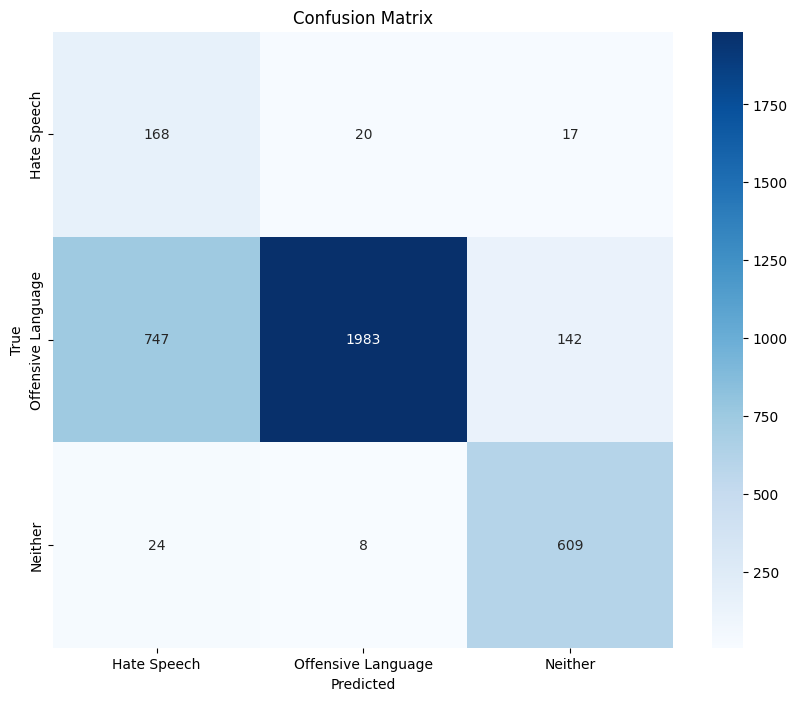

Extracting embeddings: 100%|██████████| 775/775 [01:23<00:00,  9.24it/s]


Original shape: (24783, 768), Resampled shape: (57570, 768)
Original class distribution: [ 1430 19190  4163]
Resampled class distribution: [19190 19190 19190]

Embedding + LogReg Results:
                    precision    recall  f1-score   support

       Hate Speech       0.90      0.95      0.92      3849
Offensive Language       0.94      0.86      0.90      3794
           Neither       0.96      0.99      0.97      3871

          accuracy                           0.93     11514
         macro avg       0.93      0.93      0.93     11514
      weighted avg       0.93      0.93      0.93     11514



In [ ]:
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('labeled_data.csv')

    # Keep only necessary columns
    df = df[['tweet', 'class']]

    # Print initial class distribution
    print("Initial class distribution:")
    print(df['class'].value_counts())

    # Run training pipeline
    model, tokenizer = run_training_pipeline(df)

    # Optional: Create embeddings with SMOTE
    X_resampled, y_resampled = create_embeddings_with_smote(df, model, tokenizer)

    # Optional: Train a simple classifier on embeddings
    from sklearn.linear_model import LogisticRegression

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=SEED
    )

    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("\nEmbedding + LogReg Results:")
    print(classification_report(y_test, y_pred, target_names=list(LABEL_MAP.values())))